[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/049_cv_ssd/cv_ssd.ipynb)

# Implementando SSD

En este post vamos a implementar una `red neuronal convolucional` para detección de objetos desde cero. Para ello nos inspiramos en el modelo `SSD`, una arquitectura muy utilizada por su versatilidad y eficiencia.

In [1]:
import random
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageOps
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from sklearn.datasets import fetch_openml
from torch.utils.data import DataLoader
%matplotlib inline
from pycocotools.coco import COCO
import pylab

pylab.rcParams['figure.figsize'] = (8.0, 10.0)# Import Libraries

device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os 
import cv2
from tqdm import tqdm
import numpy as np
from random import sample
from PIL import Image
import json
PATH = '/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/'
classes = os.listdir(PATH)

classes = sorted(classes)  # Ordena las carpetas alfabéticamente
print(classes)
classes_json=[]
for i, class_name in enumerate(classes):
  label=class_name+'.json'
  classes_json.append(label)

print("los",classes_json)



['bolsa', 'carton', 'papel']
los ['bolsa.json', 'carton.json', 'papel.json']


In [4]:
def loadImages(root, split=0.1):
    img_test_ = []
    img_train_ = []
    labels_test_ = []
    labels_train_ = []
    for image_class, json_class in zip(classes, classes_json):
        class_path = os.path.join(root, image_class)
        json_path = os.path.join(class_path, json_class)
        #print(type(json_path))

        with open(json_path, "r") as f:
          datajson = json.load(f)
          #print(datajson)
        
        
        test_ids = sample([x for x in range(0, len(datajson))], int(len(datajson) * split))
        for i, example in enumerate(datajson):
            image_filename = example['annotation']['filename']
            image_path = os.path.join(class_path ,image_filename)
            
            if i not in test_ids:
                img_train_.append(image_path)
                labels_train_.append(example)
            else:
                img_test_.append(image_path)
                labels_test_.append(example)
    
    return np.array(img_train_), np.array(img_test_), np.array(labels_train_), np.array(labels_test_)

In [5]:
img_train, img_test, labels_train, labels_test = loadImages(PATH, split=0.2)
print("el tamaño de las iamgenes y labels de entrenamientos",len(img_train), len(labels_train))
img_train[2] , labels_train[2]

el tamaño de las iamgenes y labels de entrenamientos 25805 25805


('/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/bolsa/20230517_161205.jpg',
 {'annotation': {'filename': '20230517_161205.jpg',
   'size': {'width': '800', 'height': '600', 'depth': '3'},
   'object': [{'name': 'bolsa',
     'bndbox': {'top': 212.0,
      'left': 285.0,
      'height': 134.0,
      'width': 149.0}}]}})

In [6]:
classes = ["background","bolsa","carton","papel"]

Las siguientes funciones nos ayudan a extraer la información que necesitamos de las anotaciones y a visualizar muestras del dataset.

In [7]:
import torch
from skimage import io
device = "cuda" if torch.cuda.is_available() else "cpu"
from skimage import color
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, trans, device):
    self.X = X
    self.y = y
    self.trans = trans
    self.device = device

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    # cargar la imágen
    img = io.imread(self.X[ix])
    return torch.from_numpy(img / 255.).float(), self.y[ix]
    #return img, self.y[ix]


In [8]:
import albumentations as A
import torchvision.transforms as transforms

trans = A.Compose([
    A.Resize(800, 600),
])

dataset = {
    'train': Dataset(img_train, labels_train , trans, device), 
    'test': Dataset(img_test ,labels_test , trans, device)
}

len(dataset['train']), len(dataset['test'])


(25805, 6451)

In [9]:
def convert_to_xxyy(top, left, height, width):
    xmin = left
    xmax = left + width
    ymin = top
    ymax = top + height
    return xmin, xmax, ymin, ymax

In [10]:
def get_sample(ix):
  img_np, label = dataset['train'][ix]
  anns = label['annotation']['object']
  #print(anns)
  if type(anns) is not list:
    anns = [anns]
  labels = np.array([classes.index(ann['name']) for ann in anns])
  #print("los bbs",labels)
  bbs = []
  for ann in anns:
      bb = ann['bndbox']
      xmin, xmax, ymin, ymax = convert_to_xxyy(int(bb['top']), int(bb['left']), int(bb['height']), int(bb['width']))
      bbs.append([xmin, ymin, xmax, ymax])
  bbs = np.array(bbs)
  #print("los bbs",bbs)
  anns = (labels, bbs)
  #print("losaddd",anns)
  return img_np, anns

In [11]:
def plot_anns(img, anns, ax=None, bg=-1):
  # anns es una tuple con (labels, bbs)
  # bbs es un array de cuadros delimitadores en formato [x_min, y_min, x_max, y_max] 
  # labels es un array que contiene la etiqueta 
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    if bg == -1 or lab != bg:
      x, y, xm, ym = bb # 2
      w, h = xm - x, ym - y # 2
      rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='blue', linewidth=2)
      text = ax.text(x, y - 10, classes[lab], {'color': 'blue'})
      text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
      ax.add_patch(rect)

Para Mostrar una Imagen

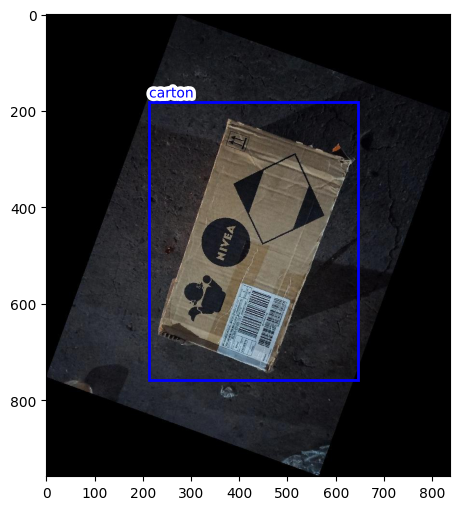

In [12]:
ix = random.randint(0,25805)
image, anns = get_sample(ix)
plot_anns(image, anns)

Para mostrar mas de una Imagen

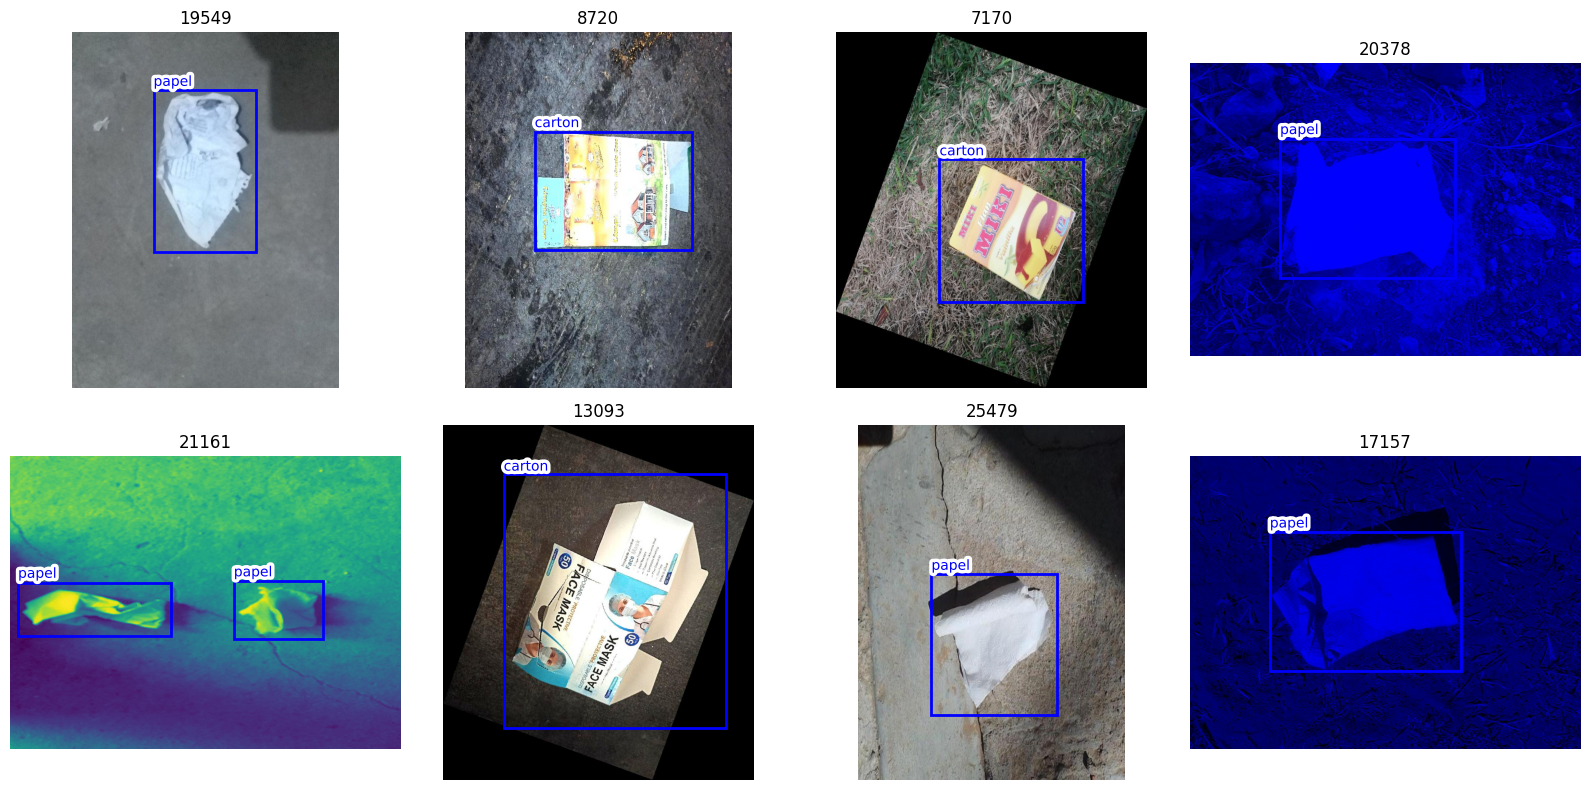

In [13]:
r, c = 2, 4
fig = plt.figure(figsize=(4*c, 4*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        ax.set_title(ix)
        img_np, anns = get_sample(ix)
        plot_anns(img_np, anns, ax)
        plt.axis("off")
plt.tight_layout()
plt.show()

Como puedes ver, en el dataset hay imágenes con una detección, otras con más de una. Algunas detecciones ocupan gran parte de la imagen, otras son pequeñas. En algunas imágenes incluso podemos tener múltiples detecciones de la misma clase... ¿Cómo podemos definir un modelo que sea capaz de darnos un número indeterminado de detecciones? En el caso del modelo `SSD`, y en general todos los detectores de una etapa, nosotros definimos un conjunto de cajas definido que la red utilizará durante el entrenamiento para generar detecciones.

## Propuesta de cajas

In [14]:
def norm(bb, shape):
  # normalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
  # unnormalize bb
  # shape = (heigh, width)
  # bb = [x_min, y_min, x_max, y_max]
  h, w = shape
  return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

def xywh2xyxy(bb):
  return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:
                for i in range(s):
                    for j in range(s):
                        # cwh
                        #anchors.append(np.array([x+i, y+j, w, h])/s)
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

A la función `generate_anchors` le damos una lista de diferentes escalas a las cuales queremos tener detecciones, otra con el centro de las cajas, la escala y el *aspect ratio*. La función nos devuelve una lista con todas las cajas que el modelo tendrá en cuenta durante el entrenamiento para detectar objetos en ellas.

In [15]:
def plot_anchors(img, anns, anchors, ax=None, overlap=False):
  if not ax:
    fig, ax = plt.subplots(figsize=(10, 6))
  ax.imshow(img)
  labels, bbs = anns

  anchors = xyxy2xywh(anchors)
  _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
  for a in _anchors:
    x, y, w, h = a
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='green', linewidth=2)
    ax.add_patch(rect)

  labels, bbs = anns
  for lab, bb in zip(labels, bbs):
    x, y, xm, ym = bb
    w, h = xm - x, ym - y
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    text = ax.text(x, y - 10, classes[lab], {'color': 'red'})
    text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
    ax.add_patch(rect)

<ipython-input-14-905d42525b09>:36: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()


(27, [3, 3, 3])

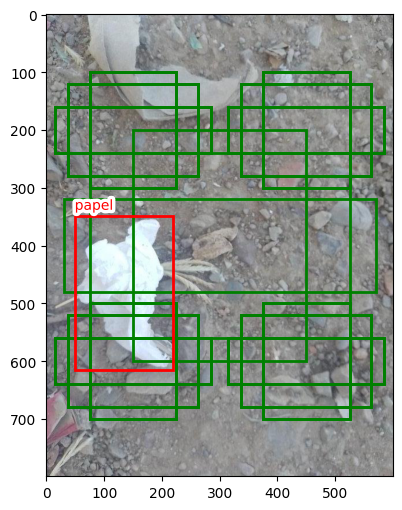

In [16]:
ix = random.randint(0,20035)
img_np, anns = get_sample(ix)
labels, bbs = anns

scales = [2,2,1]               
centers = [(0.5, 0.5)] 
size_scales = [0.5]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)
#print(k)

plot_anchors(img_np, anns, anchors)
len(anchors), k

La eficiencia y precisión del modelo dependerá del número de cajas que propongamos así como su número. Muchas cajas nos darán un modelo lento, pero potencialmente más preciso. Por otro lado, si en nuestra aplicación conocemos bien la escala y tamaño al que se encuentran los objetos que queremos detectar, poner sólo cajas en esas escalas dará como resultado un modelo preciso y eficiente (aquí estaremos introduciendo conocimiento experto, o *priors*, a nuestro modelo perdiendo flexibilidad).

Como puedes estar pensando, de querer ser capaces de detectar objetos de manera precisa simplemente con las cajas propuestas, deberíamos tener muchísimas de estas cajas (potencialmente cubriendo todo el espacio). Es por esto que nuestro modelo no sólo clasificará objetos dentro de las cajas propuestas sino que además también predecirá unos *offsets*, modificaciones sobre las cajas propuestas, para acabar de ajustar la detección (básicamente, un *offset* en el centro de la caja, su ancho y alto).

## El Modelo

Inspirándonos en la implementación del modelo `SSD` original, necesitamos una `backbone` que extraiga características de la imagen y luego varias `heads` que produzcan las clasificaciones y los *offests* sobre las cajas propuestas. Estas `heads` son alimentadas con las salidas de diferentes capas convolucionales de la `backbone`, permitiendo así la detección a múltiples escalas. Estas escalas deben coincidir con las definidas a la hora de generar nuestras propuestas de cajas (si no las dimensiones no encajarán).

![](https://miro.medium.com/max/1100/1*up-gIJ9rPkHXUGRoqWuULQ.jpeg)

In [17]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        #torch.nn.BatchNorm2d(c_out),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    return x.view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

def conv(c_i, c_o, stride=2, padding=1):
    return nn.Sequential(
        nn.Conv2d(c_i, c_o, 3, stride=stride, padding=padding), 
        nn.ReLU(),
        #nn.BatchNorm2d(c_o)
    )

class SSD(torch.nn.Module):
  def __init__(self, n_channels=3, n_classes=4, k=[1, 1, 1]):
    super().__init__()
    # backbone
    self.conv1 = block(n_channels, 8)
    self.conv2 = block(8, 16)
    self.conv3 = block(16, 32)
    self.conv4 = block(32, 64)
    self.conv5 = block(64, 64)
    self.conv6 = block(64, 64)
    # head
    self.k = k
    self.out4 = out_conv(64, self.k[0], n_classes)
    self.out5 = out_conv(64, self.k[1], n_classes)
    self.out6 = out_conv(64, self.k[2], n_classes)

  def forward(self, x):
    # backbone
    x = self.conv1(x)
    #print(x.shape,"x1")
    x = self.conv2(x)
    #print(x.shape,"x2")
    x = self.conv3(x)     # para inputs de 100x100
    #print(x.shape,"x3")
    x4 = self.conv4(x)    # 6x6
    #print(x4.shape,"x4")
    x5 = self.conv5(x4)   # 3x3
    #print(x5.shape,"x5")
    x6 = self.conv6(x5)   # 1x1
    #print(x6.shape,"x6")

    # head
    o1l, o1c = self.out4(x4)
    #print("1",o1l.shape,"2",o1c.shape)
    o2l, o2c = self.out5(x5)
    #print("1",o2l.shape,"2",o2c.shape)
    o3l, o3c = self.out6(x6)
    #print("1",o3l.shape,"2",o3c.shape)
    #return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)    
    return o2l, o2c

In [18]:
net = SSD(n_classes=len(classes), k=[3,3,3])
output = net(torch.rand((32,3,100,100)))
output[0].shape, output[1].shape

(torch.Size([32, 27, 4]), torch.Size([32, 27, 4]))

## La función de pérdida

Durante el entrenamiento, el modelo nos dará 4 valores para cada una de las cajas propuestas (*offests*) así como las 3 probabilidades asignadas a cada clase. De alguna manera, la función de pérdida tiene que comparar estos valores con las cajas reales. En primer lugar tenemos que coger las salidas del modelo y calcular los *offsets*. Para ello, usaremos la función `tanh`, que limita los salidas a valores en el rango (-1, 1), permitiendo un *offset* de hasta el 50% del tamaños de la caja en ambas dimensiones.

In [19]:
def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn)
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
    return torch.cat([actn_p1, actn_p2], dim=1)

El siguiente problema es que cada imagen tiene un número indeterminado de detecciones, por lo que primero tenemos que emparejar las cajas propuestas con aquellas anotaciones con las que mejor coincidan. Para ello usamos una métrica conocida como `IoU`(*intersection over unions*).

![](https://pyimagesearch.com/wp-content/uploads/2016/09/iou_equation.png)

Una vez calculado este valor para cada caja propuesta con respecto a todas las cajas en las etiquetas, nos quedamos con aquellas que superen un `threshold` determinado (por defecto 0.4). Es posible pues tener varias detecciones para un mismo objeto, algo que resolveremos más adelante. También puede ocurrir que no haya ninguna caja que cumpla estos requisitos, es este caso le asignaremos aquella con mayor `IoU`.

In [20]:
def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

Una vez hemos determinado las cajas que mejor aproximan las detecciones reales, usamos una combinación de `L1Loss` y `CrossEntropyLoss` para la localización y clasificación, respectivamente, igual que hicimos en este [post](https://sensioai.com/blog/047_cv_loc_clas).

In [21]:
class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss()
        self.class_loss = torch.nn.CrossEntropyLoss()
        self.anchors = anchors.to(device)
        self.grid_size = grid_size.to(device)
        self.threshold = threshold

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds 
        tar_bbs, c_t = target # B x O x 4, B x O
        # cada imagen del batch puede tener un número diferente de detecciones
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device) # por defecto todas las etiquetas son `background`
            if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones
                # calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
                # nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                pos = gt_overlap > self.threshold
                # optimizamos para aquellas cajas que superen el filtro
                pos_idx = torch.nonzero(pos)[:,0]
                tar_idx = gt_idx[pos_idx]
                pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
                _anchors = pred_bb[pos_idx]
                tar_bb = tar_bb[tar_idx]
                loc_loss += self.loc_loss(_anchors, tar_bb)
                labels[pos_idx] = tar_c[tar_idx]
                clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss

<>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-21-2541eadb832f>:17: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if tar_bb.shape[0] is not 0: # es posible que haya imágenes sin detecciones


## Entrenamiento para una imagen

Ahora ya tenemos todas las piezas en sus sitio para entrenar nuestro modelo. Vamos a hacer el fit de una sola imagen para simplificar las cosas de momento.

In [22]:
def fit(model, X, target, epochs=1, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    for epoch in range(1, epochs+1):
        model.train()
        train_loss_loc, train_loss_cls = [], []
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        train_loss_loc.append(loss.item())
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss_loc):.5f}")

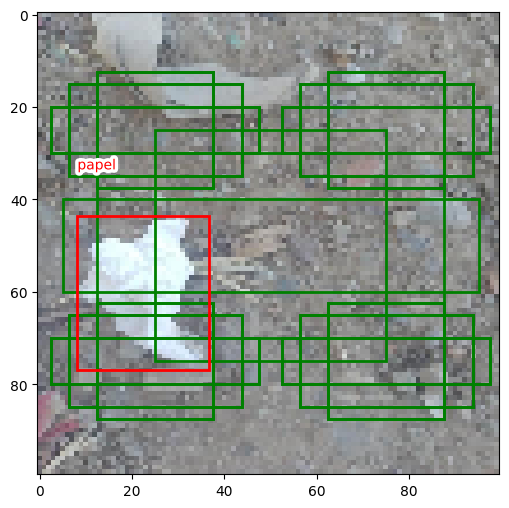

In [23]:
import albumentations as A

trans = A.Compose([
    A.Resize(100, 100)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
img_np = np.array(img_np)
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
#print(augmented)

img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

Hemos diseñado nuestra red y nuestras cajas propuestas para trabajar con imágenes de 100 x 100 pixeles. Utilizamos albumentations para hacer el *resize* de la imagen y anotaciones.

In [24]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device)
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

img_tensor.shape, bb_tensor.shape, label_tensor.shape

(torch.Size([1, 3, 100, 100]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [25]:
model = SSD(n_classes = len(classes), k=[3,3,3])

fit(model, img_tensor, (bb_tensor, label_tensor), epochs=200)

Epoch 1/200 loss 1.46061
Epoch 2/200 loss 1.45317
Epoch 3/200 loss 1.44594
Epoch 4/200 loss 1.43866
Epoch 5/200 loss 1.43081
Epoch 6/200 loss 1.42215
Epoch 7/200 loss 1.41251
Epoch 8/200 loss 1.40234
Epoch 9/200 loss 1.39085
Epoch 10/200 loss 1.37753
Epoch 11/200 loss 1.36224
Epoch 12/200 loss 1.34470
Epoch 13/200 loss 1.32457
Epoch 14/200 loss 1.30142
Epoch 15/200 loss 1.27483
Epoch 16/200 loss 1.24431
Epoch 17/200 loss 1.20947
Epoch 18/200 loss 1.17133
Epoch 19/200 loss 1.13047
Epoch 20/200 loss 1.08418
Epoch 21/200 loss 1.03237
Epoch 22/200 loss 0.97558
Epoch 23/200 loss 0.91274
Epoch 24/200 loss 0.84395
Epoch 25/200 loss 0.77001
Epoch 26/200 loss 0.69382
Epoch 27/200 loss 0.62122
Epoch 28/200 loss 0.54968
Epoch 29/200 loss 0.48004
Epoch 30/200 loss 0.41726
Epoch 31/200 loss 0.36637
Epoch 32/200 loss 0.32285
Epoch 33/200 loss 0.28650
Epoch 34/200 loss 0.25761
Epoch 35/200 loss 0.23626
Epoch 36/200 loss 0.21973
Epoch 37/200 loss 0.20662
Epoch 38/200 loss 0.19652
Epoch 39/200 loss 0.1

## Generando predicciones

Una vez tenemos nuestro modelo entrenado, podemos generar predicciones de la siguiente manera

In [26]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [27]:
bbs, (scores, labels) = predict(model, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

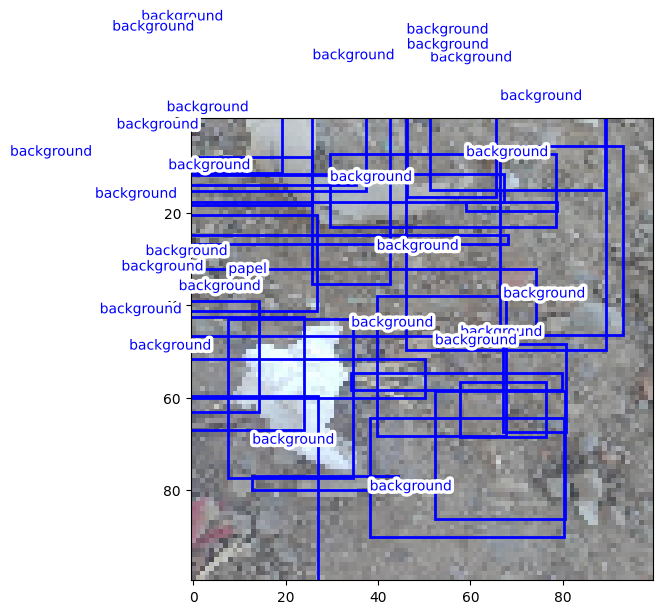

In [28]:
plot_anns(img, (labels, bbs))
plt.show()

Tenemos tantas predicciones como cajas propuestas, y la mayoría por defecto tendrán asignada la clase `background` que no nos interesa, así que descartamos todas estas cajas.

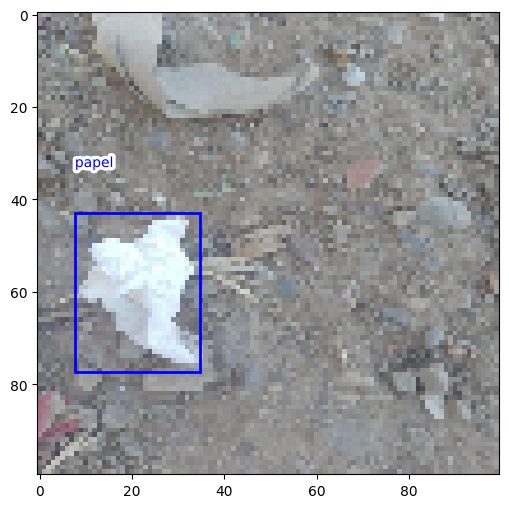

In [29]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

Aún así, es posible que tengamos varias detecciones para un mismo objeto. Para resolver este problema podemos aplicar el algoritmo `NMS`(*non maximum supression*) que calcula el `IoU` de las detecciones con la misma clase y, si este valor está por encima de un cierto *threshold*, devuelve solo la detección con mayor probabilidad.

In [30]:
bbs, (scores, labels) = predict(model, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

(tensor([[0.0762, 0.4299, 0.3463, 0.7744]]), tensor([3]), tensor([0.9712]))

In [31]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

tensor([0])

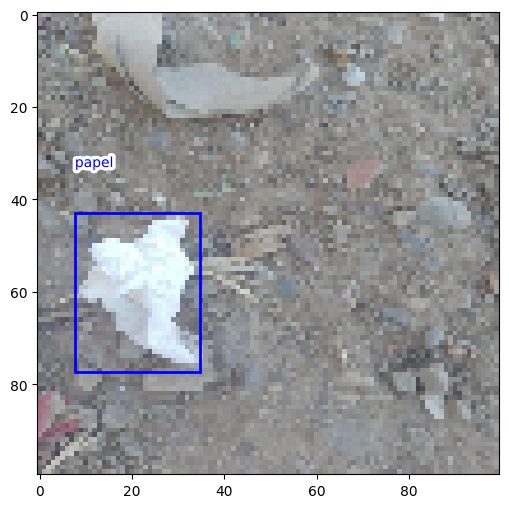

In [32]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

TRANSFER LEARNIG (REGNETX400MF)

In [33]:
model2=torchvision.models.regnet_x_400mf(pretrained=True)
model2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_x_400mf-adf1edd5.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-adf1edd5.pth
100%|██████████| 21.3M/21.3M [00:00<00:00, 87.0MB/s]


RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

In [34]:
import torch
import torch.nn as nn
from torchvision.models import mnasnet0_5

class MNASNETSSD(nn.Module):
    def __init__(self, n_channels=3, n_classes=21, k=[1, 1, 1]):
        super().__init__()
        # backbone
        self.regnet = torchvision.models.regnet_x_400mf(pretrained=True)           
        self.regnet.stem[0] = torch.nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3, bias=False)

        self.conv3 = block(160,64)
        self.conv4 = block(64,64)
        self.conv5 = block(64,64)

        # head
        self.k = k
        self.out4 = out_conv(64, self.k[0], n_classes)
        self.out5 = out_conv(64, self.k[1], n_classes)
        self.out6 = out_conv(64, self.k[2], n_classes)

        
    def forward(self, x):
        # backbone
        # backbone
        x1 = self.regnet.stem(x)
        #print("x3",x1.shape)
        x2 = self.regnet.trunk_output.block1(x1)
        #print("x2",x2.shape)
        x3 = self.regnet.trunk_output.block2(x2)
        #print("x3",x3.shape)
        x4 = self.regnet.trunk_output.block3(x3)
        #print("x4",x4.shape)
        xc=self.conv3(x4)
        #print("xc",xc.shape)
        xc1=self.conv4(xc)
        #print("xc1",xc1.shape)
        xc2=self.conv5(xc1)
        #print("xc2",xc2.shape)
        # head
        o1l, o1c = self.out4(xc)
        #print("1",o1l.shape,"2",o1c.shape)
        o2l, o2c = self.out5(xc1)
        #print("1",o2l.shape,"2",o2c.shape)
        o3l, o3c = self.out6(xc2)
        #print("1",o3l.shape,"2",o3c.shape)

        return o2l, o2c


In [35]:
net = MNASNETSSD(n_classes=len(classes), k=[3,3,3])
#print("net",net)
input_tensor = torch.rand((3, 3, 200, 200))
output = net(input_tensor)
print(output[0].shape, output[1].shape)

torch.Size([3, 27, 4]) torch.Size([3, 27, 4])


In [36]:
#ix = random.randint(0,2000)
#img_np, anns = get_sample(ix)
#labels, bbs = anns

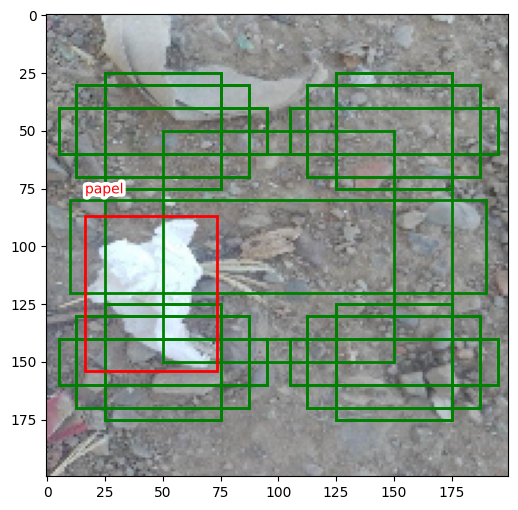

In [37]:
import albumentations as A

trans = A.Compose([
    A.Resize(200, 200)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

labels, bbs = anns
img_np = np.array(img_np)
augmented = trans(**{'image': img_np, 'bboxes': bbs, 'labels': labels})
img, bbs, labels = augmented['image'], augmented['bboxes'], augmented['labels']

plot_anchors(img, (labels, bbs), anchors)
plt.show()

In [38]:
img_tensor = torch.FloatTensor(img / 255.).permute(2,0,1).unsqueeze(0).to(device)
bb_norm = [norm(bb, img.shape[:2]) for bb in bbs]
bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0).to(device)
label_tensor = torch.tensor(labels).long().unsqueeze(0).to(device)

img_tensor.shape, bb_tensor.shape, label_tensor.shape

(torch.Size([1, 3, 200, 200]), torch.Size([1, 1, 4]), torch.Size([1, 1]))

Entrenamiento para una Imagen con el modelo regnet_x_400mf

In [39]:
regnet = MNASNETSSD(n_classes = len(classes), k=k)
#model = SSDException(n_classes = len(classes), k=k)

fit(regnet, img_tensor, (bb_tensor, label_tensor), epochs=100)

Epoch 1/100 loss 1.43733
Epoch 2/100 loss 1.24161
Epoch 3/100 loss 1.06599
Epoch 4/100 loss 0.89309
Epoch 5/100 loss 0.70709
Epoch 6/100 loss 0.53117
Epoch 7/100 loss 0.37873
Epoch 8/100 loss 0.28522
Epoch 9/100 loss 0.23026
Epoch 10/100 loss 0.21929
Epoch 11/100 loss 0.19402
Epoch 12/100 loss 0.17044
Epoch 13/100 loss 0.16442
Epoch 14/100 loss 0.16791
Epoch 15/100 loss 0.14162
Epoch 16/100 loss 0.12930
Epoch 17/100 loss 0.11166
Epoch 18/100 loss 0.08656
Epoch 19/100 loss 0.07974
Epoch 20/100 loss 0.08410
Epoch 21/100 loss 0.08288
Epoch 22/100 loss 0.06361
Epoch 23/100 loss 0.08463
Epoch 24/100 loss 0.09309
Epoch 25/100 loss 0.07153
Epoch 26/100 loss 0.06415
Epoch 27/100 loss 0.05211
Epoch 28/100 loss 0.06523
Epoch 29/100 loss 0.06758
Epoch 30/100 loss 0.05658
Epoch 31/100 loss 0.07058
Epoch 32/100 loss 0.07127
Epoch 33/100 loss 0.06033
Epoch 34/100 loss 0.04069
Epoch 35/100 loss 0.04154
Epoch 36/100 loss 0.05373
Epoch 37/100 loss 0.05954
Epoch 38/100 loss 0.05247
Epoch 39/100 loss 0.0

In [40]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)
        bbs = actn_to_bb(bbs[0].cpu(), anchors, grid_size)
    return bbs, torch.max(torch.softmax(labels.cpu(), axis=2)[0], axis=1)

In [41]:
bbs, (scores, labels) = predict(regnet, img_tensor)
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]

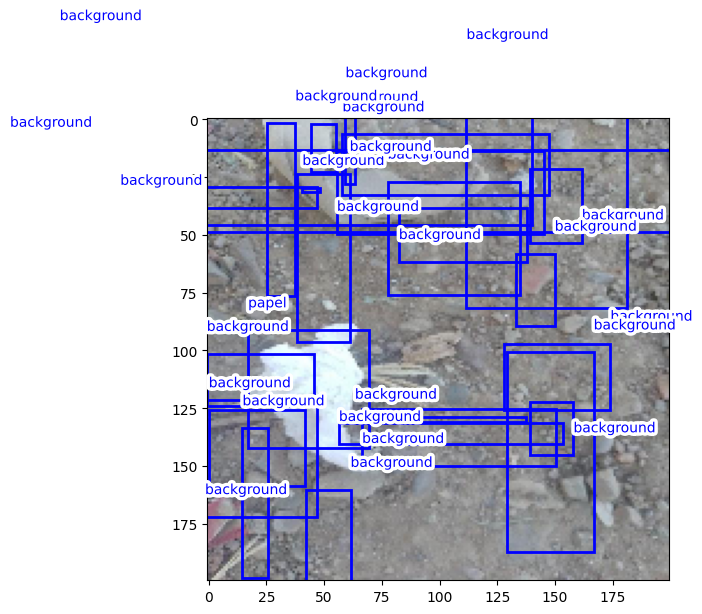

In [42]:
plot_anns(img, (labels, bbs))
plt.show()

In [43]:
bbs, (scores, labels) = predict(regnet, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

(tensor([[0.0855, 0.4567, 0.3466, 0.7120]]), tensor([3]), tensor([0.5471]))

In [44]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs

tensor([0])

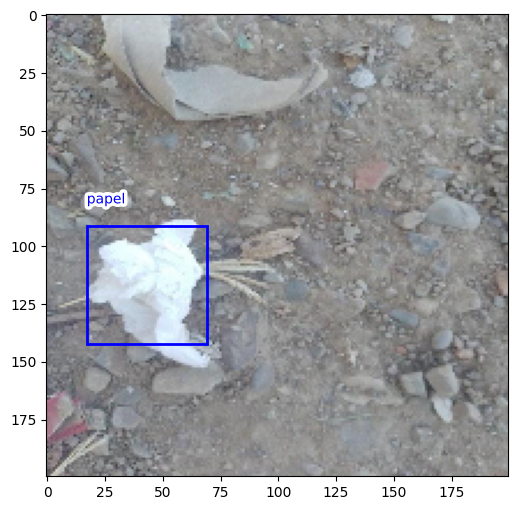

In [45]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

ENTRENAMINETO CON TODO EL DATASET

In [46]:
classses=['background',"bolsa","carton","papel","plastico","vidrio"]

In [47]:
def convert_to_xxyy(top, left, height, width):
    xmin = left
    xmax = left + width
    ymin = top
    ymax = top + height
    return xmin, xmax, ymin, ymax

In [49]:
import json
import cv2
from sklearn.model_selection import train_test_split
import numpy as np

# Lista para almacenar los datos de las imágenes y etiquetas
dataset = []
img_train = []
img_test = []
bndbox_train = []
bndbox_test = []
labels_train = []
labels_test = []

# Leer los archivos JSON
root='/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/'
json_files = ["/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/carton/carton.json", "/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/papel/papel.json"]
clss=['carton','papel']
for cls ,json_file in zip(clss, json_files):
    with open(json_file, 'r') as f:
        data = json.load(f)

        
        # Extraer la información relevante
        for annotation in data:
            filename = annotation['annotation']['filename']
            objects = annotation['annotation']['object']
            #print(objects)
            name = objects[0]['name']
            #print(name,type(name))
            
            #labels = []
            bndboxes = []
            for obj in objects:
                label = obj['name']
                #print(label)
                clase=classses.index(label)
                bbox = obj['bndbox']
                coordinates = (bbox['top'], bbox['left'], bbox['height'], bbox['width'])
                #print(coordinates)
                xmin, xmax, ymin, ymax = convert_to_xxyy(int(bbox['top']), int(bbox['left']), int(bbox['height']), int(bbox['width']))
                bndboxes = [xmin, ymin, xmax, ymax]
                #labels.append(clase)
            
            # Leer la imagen correspondiente
            image_path = "/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/"+cls+"/"+filename
            #print(image_path)
            if np.random.rand() < 0.2:  # 10% para prueba
                img_test.append(image_path)
                bndbox_test.append(bndboxes)
                labels_test.append(clase)
            else:  # 90% para entrenamiento
                img_train.append(image_path)
                bndbox_train.append(bndboxes)
                labels_train.append(clase)


img_train = np.array(img_train)
img_test = np.array(img_test)
bndbox_train = np.array(bndbox_train)
bndbox_test = np.array(bndbox_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)           
#data=np.array(dataset)
#print(data)
# Dividir los datos en conjuntos de entrenamiento y prueba
#train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
len(img_train), len(labels_train), len(bndbox_train)


(25124, 25124, 25124)

In [50]:
ix =  random.randint(0,25805)
img_train[ix],labels_train[ix], bndbox_train[ix]

('/content/drive/MyDrive/SIS421/2Parcial/datasetbasura/papel/papel (671)_sharpened.jpg',
 3,
 array([264, 200, 564, 404]))

In [51]:
from skimage import io
from torchvision import transforms
import numpy as np

from PIL import Image
import numpy as np
class Dataset2(torch.utils.data.Dataset):
    def __init__(self, X, label, bndbox, trans, device):
        self.X = X
        self.label = label
        self.bndbox = bndbox
        self.trans = trans
        self.device = device

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        img = io.imread(self.X[ix])
        if len(img.shape) >= 3 and img.shape[2] == 4:
            img = color.rgba2rgb(img)
        elif len(img.shape) < 3:
            # Handle grayscale images or images with incorrect format
            img = color.gray2rgb(img)
        if self.trans:
          img = self.trans(image=img)["image"]
        #img = Image.fromarray(img)  # Convierte la imagen a formato PIL.Image
        img_tensor = torch.FloatTensor(img / 255.).permute(2, 0, 1)
        
        bb_norm = norm(self.bndbox[ix], img.shape[:2])
        bb_tensor = torch.FloatTensor(bb_norm).unsqueeze(0)
        
        label_tensor =  torch.tensor(self.label[ix]).long().unsqueeze(0)
        
        return img_tensor, bb_tensor, label_tensor

In [52]:
import albumentations as A
from skimage import color
trans = A.Compose([
    A.Resize(200, 200)
])

dataset2 = {
    'train': Dataset2(img_train, labels_train ,bndbox_train, trans, device), 
    'test': Dataset2(img_test ,labels_test ,bndbox_test, trans, device)
}

len(dataset2['train']), len(dataset2['test'])

(25124, 6132)

In [53]:
dataloader2 = {
    'train': torch.utils.data.DataLoader(dataset2['train'], batch_size=32, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset2['test'], batch_size=32, pin_memory=True)
}

imgs,label, bndx = next(iter(dataloader2['train']))
#print(bndx)
imgs.shape,label.shape, bndx.shape

(torch.Size([32, 3, 200, 200]), torch.Size([32, 1, 4]), torch.Size([32, 1]))

In [54]:
from tqdm import tqdm
def fit2(model, dataloader2, epochs=1, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)
    model.to(device)
    hist = {'loss': [], 'test_loss': []}
    for epoch in range(1, epochs+1):
        bar = tqdm(dataloader2['train'])
        model.train()
        train_loss_loc, train_loss_cls = [], []
        for images,targets, bnbx in bar:
            images = images.to(device)
           #print(images)
            #images = images.unsqueeze(0)  # Agregar dimensión del canal (batch_size = 1)
            targets = [target.to(device) for target in targets]
            bnbx = [bn.to(device) for bn in bnbx]
            #print(bnbx)
            #print(targets)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, (targets,bnbx))
            loss.backward()
            optimizer.step()
            train_loss_loc.append(loss.item())
        model.eval()
        test_loss_loc = []
        bar = tqdm(dataloader2['test'])
        with torch.no_grad():
          for images, targets,bnbx in bar:
            images = images.to(device)
            targets = [target.to(device)  for target in targets]
            bnbx = [bn.to(device) for bn in bnbx]
            outputs = model(images)
            loss = criterion(outputs, (targets,bnbx))
            test_loss_loc.append(loss.item())
        hist['loss'].append(np.mean(train_loss_loc))
        hist['test_loss'].append(np.mean(test_loss_loc))
        print(f"Epoch {epoch}/{epochs} | Average Train Loss: {np.mean(train_loss_loc):.5f} | Average Test Loss: {np.mean(test_loss_loc):.5f}")
    return hist

In [55]:
fit2(regnet,dataloader2, epochs=1)

100%|██████████| 192/192 [23:13<00:00,  7.26s/it]

Epoch 1/1 | Average Train Loss: 46.12037 | Average Test Loss: 45.34865


{'loss': [46.120368269563635], 'test_loss': [45.348653177420296]}

In [67]:
def get_sampleText(ix):
  img_np,  bnbx,target  = dataset2['test'][ix]
  print(img_np)
  labels= target
  print(img_np,bbs,labels)

  return img_np, bbs, labels

In [71]:
ix = random.randint(0,4000)
image, anns ,labels = get_sampleText(ix)
# Convertir la imagen a tensor
image_tamano = image.permute(1, 2, 0).reshape(200, 200, 3)

type(image_tamano)
image_tamano.shape[:2]

tensor([[[0.7608, 0.7216, 0.6627,  ..., 0.7176, 0.7529, 0.7490],
         [0.8078, 0.7059, 0.7765,  ..., 0.6863, 0.7098, 0.7529],
         [0.7333, 0.7294, 0.7412,  ..., 0.6784, 0.6275, 0.7333],
         ...,
         [0.2314, 0.2353, 0.2275,  ..., 0.8196, 0.8196, 0.8078],
         [0.2275, 0.2314, 0.2784,  ..., 0.8000, 0.8039, 0.8118],
         [0.2314, 0.2588, 0.2471,  ..., 0.7725, 0.8039, 0.8157]],

        [[0.7490, 0.7098, 0.6510,  ..., 0.6784, 0.7137, 0.7098],
         [0.7961, 0.6941, 0.7647,  ..., 0.6471, 0.6706, 0.7137],
         [0.7216, 0.7176, 0.7294,  ..., 0.6392, 0.5882, 0.6941],
         ...,
         [0.1961, 0.2118, 0.2078,  ..., 0.6118, 0.6118, 0.6000],
         [0.1922, 0.2078, 0.2588,  ..., 0.5922, 0.5961, 0.6039],
         [0.1961, 0.2353, 0.2275,  ..., 0.5647, 0.5961, 0.6078]],

        [[0.7216, 0.6824, 0.6235,  ..., 0.6392, 0.6745, 0.6706],
         [0.7686, 0.6667, 0.7373,  ..., 0.6078, 0.6314, 0.6745],
         [0.6941, 0.6902, 0.7020,  ..., 0.6000, 0.5490, 0.

torch.Size([200, 200])

In [73]:
image_tenseor = image.unsqueeze(0)  # Agregar una dimensión extra

bbs, (scores, labels) = predict(regnet, image_tenseor)
bbs = [unnorm(bb, image_tamano.shape[:2]) for bb in bbs]

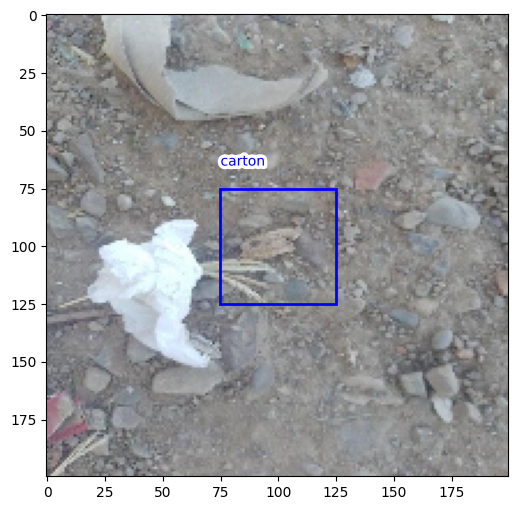

In [74]:
plot_anns(img, (labels, bbs), bg=0)
plt.show()

In [76]:
bbs, (scores, labels) = predict(regnet, img_tensor)
# quitar bg
bbs, labels, scores = bbs[labels > 0], labels[labels > 0], scores[labels > 0]
bbs, labels, scores

(tensor([[0.3743, 0.3742, 0.6249, 0.6249]]), tensor([2]), tensor([0.7619]))

In [77]:
nms_ixs = torchvision.ops.nms(bbs, scores, iou_threshold=0.8)
nms_ixs


tensor([0])

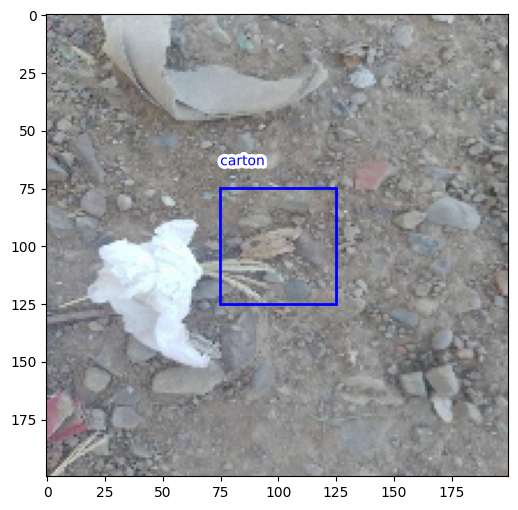

In [78]:
bbs, labels = bbs[nms_ixs], labels[nms_ixs]
bbs = [unnorm(bb, img.shape[:2]) for bb in bbs]
plot_anns(img, (labels, bbs))
plt.show()

Ahora puedes intentar entrenar este modelo para el resto de imágenes del dataset. Es posible aplicar *transfer learning*, sustituyendo nuestra `bakcbone` por una red preentrenada (por ejemplo `resenet`) y sacando las cabezas de detecciones de los diferentes mapas de características intermedios (puedes añadir capas extras para seguir reduciendo la dimensionalidad como en la implementación original).

## Resumen

En este post hemos aprendido a implementar un modelo de detección de objetos desde cero, inspirándonos en el modelo `SSD`. En primer lugar, hemos definido un conjunto de cajas que durante el entrenamiento nuestra red utilizará para detectar objetos. La salida de la red neuronal nos dará unos *offsets* sobre estas cajas a la vez que la distribución de probabilidad sobre todos los posibles objetos. Utilizamos la métric `IoU` para determinar qué cajas se parecen más a las anotaciones, y optimizar para sólo este conjunto. Por último, utilizamos el algorimto `NMS` para eliminar duplicados a la hora de generar predicciones.